# Bayesian Hierarchical Linear Regression

**Disclaimer** This notebook is an adaptation of [Bayesian Hierarchical Linear Regression](https://github.com/pyro-ppl/numpyro/blob/a66391dfed461fc48d6b082b10c76a1c1d75a9af/notebooks/source/bayesian_hierarchical_linear_regression.ipynb) implemented in NumPyro. 

Original author in NumPyro is [Carlos Souza](mailto:souza@gatech.edu). Updated by [Chris Stoafer](cstoafer@gmail.com) in NumPyro. Adapted to RxInfer by Dmitry Bagaev.

In [2]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate()

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


Probabilistic Machine Learning models can not only make predictions about future data but also model uncertainty. In areas such as personalized medicine, there might be a large amount of data, but there is still a relatively small amount available for each patient. To customize predictions for each person, it becomes necessary to build a model for each individual — considering its inherent uncertainties — and then couple these models together in a hierarchy so that information can be borrowed from other similar individuals [1].

The purpose of this tutorial is to demonstrate how to implement a Bayesian Hierarchical Linear Regression model using NumPyro. To provide motivation for the tutorial, I will use the [OSIC Pulmonary Fibrosis Progression competition](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression), hosted on Kaggle.

In [3]:
using DataFrames, Plots, CSV, StatsPlots, GLM, BenchmarkTools

In [4]:
# https://www.machinelearningplus.com/linear-regression-in-julia/
# https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_hierarchical_linear_regression.ipynb

# Understanding the Task

Pulmonary fibrosis is a disorder characterized by scarring of the lungs, and its cause and cure are currently unknown. In this competition, the objective was to predict the severity of decline in lung function for patients. Lung function is assessed based on the output from a spirometer, which measures the forced vital capacity (FVC), representing the volume of air exhaled.

In medical applications, it is valuable to evaluate a model's confidence in its decisions. As a result, the metric used to rank the teams was designed to reflect both the accuracy and certainty of each prediction. This metric is a modified version of the Laplace Log Likelihood (further details will be provided later).

Now, let's explore the data and delve deeper into the problem involved.

In [5]:
dataset = CSV.read("../data/hbr/osic_pulmonary_fibrosis.csv", DataFrame);

In [6]:
describe(dataset)

7×7 DataFrame
 Row │ variable       mean     min                        median   max         ⋯
     │ Symbol         Union…   Any                        Union…   Any         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Patient                 ID00007637202177411956430           ID004266372 ⋯
   2 │ Weeks          31.8618  -5                         28.0     133
   3 │ FVC            2690.48  827                        2641.0   6399
   4 │ Percent        77.6727  28.8776                    75.6769  153.145
   5 │ Age            67.1885  49                         68.0     88          ⋯
   6 │ Sex                     Female                              Male
   7 │ SmokingStatus           Currently smokes                    Never smoke
                                                               3 columns omitted

In [7]:
first(dataset, 5)

5×7 DataFrame
 Row │ Patient                    Weeks  FVC    Percent  Age    Sex      Smoki ⋯
     │ String31                   Int64  Int64  Float64  Int64  String7  Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ID00007637202177411956430     -4   2315  58.2536     79  Male     Ex-sm ⋯
   2 │ ID00007637202177411956430      5   2214  55.7121     79  Male     Ex-sm
   3 │ ID00007637202177411956430      7   2061  51.8621     79  Male     Ex-sm
   4 │ ID00007637202177411956430      9   2144  53.9507     79  Male     Ex-sm
   5 │ ID00007637202177411956430     11   2069  52.0634     79  Male     Ex-sm ⋯
                                                                1 column omitted

The dataset provided us with a baseline chest CT scan and relevant clinical information for a group of patients. Each patient has an image taken at Week = 0, and they undergo numerous follow-up visits over approximately 1-2 years, during which their Forced Vital Capacity (FVC) is measured. For the purpose of this tutorial, we will only consider the Patient ID, the weeks, and the FVC measurements, discarding all other information. Restricting our analysis to these specific columns allowed our team to achieve a competitive score, highlighting the effectiveness of Bayesian hierarchical linear regression models, especially when dealing with uncertainty, which is a crucial aspect of the problem.

Since this is real medical data, the relative timing of FVC measurements varies widely, as shown in the 3 sample patients below:

In [8]:
patientinfo(dataset, patient_id) = filter(:Patient => ==(patient_id), dataset)

patientinfo (generic function with 1 method)

In [9]:
function patientchart(dataset, patient_id; line_kws = true)
    info = patientinfo(dataset, patient_id)
    x = info[!, "Weeks"]
    y = info[!, "FVC"]

    p = plot(tickfontsize = 10, margin = 1Plots.cm, size = (400, 400), titlefontsize = 11)
    p = scatter!(p, x, y, title = patient_id, legend = false, xlabel = "Weeks", ylabel = "FVC")
    
    if line_kws
        # Use the `GLM.jl` package to estimate linear regression
        linearFormulae = @formula(FVC ~ Weeks)
        linearRegressor = lm(linearFormulae, patientinfo(dataset, patient_id))
        linearPredicted = predict(linearRegressor)
        p = plot!(p, x, linearPredicted, color = :red, lw = 3)
    end

    return p
end

patientchart (generic function with 1 method)

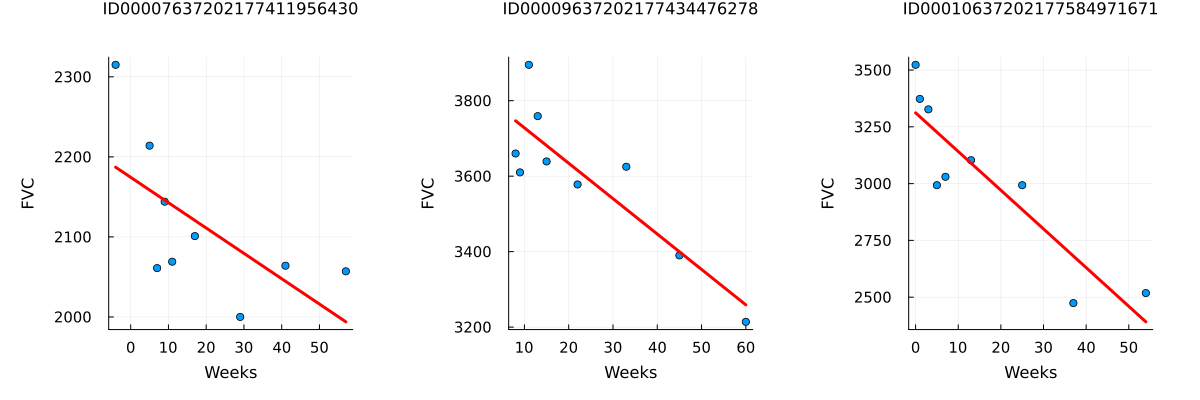

In [10]:
p1 = patientchart(dataset, "ID00007637202177411956430")
p2 = patientchart(dataset, "ID00009637202177434476278")
p3 = patientchart(dataset, "ID00010637202177584971671")

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1200, 400))

On average, each of the 176 patients provided in the dataset had 9 visits during which their FVC was measured. These visits occurred at specific weeks within the interval `[-12, 133]`. The decline in lung capacity is evident, but it also varies significantly from one patient to another.

Our task was to predict the FVC measurements for each patient at every possible week within the `[-12, 133]` interval, along with providing a confidence score for each prediction. In other words, we were required to fill a matrix, as shown below, with the predicted values and their corresponding confidence scores:

![](./pics/hblr-matrix-completion.jpeg)

The task was ideal for applying Bayesian inference. However, the vast majority of solutions shared within the Kaggle community utilized discriminative machine learning models, disregarding the fact that most discriminative methods struggle to provide realistic uncertainty estimates. This limitation stems from their typical training process, which aims to optimize parameters to minimize certain loss criteria (such as predictive error). As a result, these models do not inherently incorporate uncertainty into their parameters or subsequent predictions. While some methods may produce uncertainty estimates as a by-product or through post-processing steps, these are often heuristic-based and lack a statistically principled approach to estimate the target uncertainty distribution [2].

# 2. Modelling: Bayesian Hierarchical Linear Regression with Partial Pooling

In a basic linear regression, which is not hierarchical, the assumption is that all FVC decline curves share the same α and β values. This model is known as the "pooled model." On the other extreme, we could assume a model where each patient has a personalized FVC decline curve, and these curves are entirely independent of one another. This model is referred to as the "unpooled model," where each patient has completely separate regression lines.

In this analysis, we will adopt a middle ground approach known as "Partial pooling." Specifically, we will assume that while α's and β's are different for each patient, as in the unpooled case, these coefficients share some similarities. This partial pooling will be achieved by modeling each individual coefficient as being drawn from a common group distribution.:

Mathematically, the model is described by the following equations:

$$\begin{equation}
    \begin{aligned}
        \mu_\alpha &\sim \mathcal{N}(\mathrm{mean} = 0.0, \mathrm{variance} = 250000.0) \\
        \sigma_\alpha &\sim \mathcal{\Gamma}(\mathrm{shape} = 1.75, \mathrm{scale} = 45.54) \\
        \mu_\beta &\sim \mathcal{N}(\mathrm{mean} = 0.0, \mathrm{variance} = 9.0) \\
        \sigma_\beta &\sim \mathcal{\Gamma}(\mathrm{shape} = 1.75, \mathrm{scale} = 1.36) \\
        \alpha_i &\sim \mathcal{N}(\mathrm{mean} = \mu_\alpha, \mathrm{precision} = \sigma_\alpha) \\
        \beta &\sim \mathcal{N}(\mathrm{mean} = \mu_\beta, \mathrm{precision} = \sigma_\beta) \\
        \sigma &\sim \mathcal{\Gamma}(\mathrm{shape} = 1.75, \mathrm{scale} = 45.54) \\
        \mathrm{FVC}_{ij} &\sim \mathcal{N}(\mathrm{mean} = \alpha_i + t \beta_i, \mathrm{precision} = \sigma)
    \end{aligned}
\end{equation}$$

where `t` is the time in weeks. Those are very uninformative priors, but that's ok: our model will converge!

Implementing this model in `RxInfer` is pretty straightforward:

In [11]:
using RxInfer

In [12]:
@model function partially_pooled(patient_codes, weeks)
    μ_α ~ Normal(mean = 0.0, var = 250000.0) # Prior for the mean of α (intercept)
    μ_β ~ Normal(mean = 0.0, var = 9.0)      # Prior for the mean of β (slope)
    σ_α ~ Gamma(shape = 1.75, scale = 45.54) # Prior for the precision of α (intercept)
    σ_β ~ Gamma(shape = 1.75, scale = 1.36)  # Prior for the precision of β (slope)

    n_codes = length(patient_codes)            # Total number of data points
    n_patients = length(unique(patient_codes)) # Number of unique patients in the data

    α = randomvar(n_patients)                # Individual intercepts for each patient
    β = randomvar(n_patients)                # Individual slopes for each patient

    for i in 1:n_patients
        α[i] ~ Normal(mean = μ_α, precision = σ_α) # Sample the intercept α from a Normal distribution
        β[i] ~ Normal(mean = μ_β, precision = σ_β) # Sample the slope β from a Normal distribution
    end

    σ ~ Gamma(shape = 1.75, scale = 45.54)   # Prior for the standard deviation of the error term
    
    FVC_est = randomvar(n_codes)
    data = datavar(Int, n_codes) # Observed FVC measurements

    for i in 1:n_codes
        FVC_est[i] ~ α[patient_codes[i]] + β[patient_codes[i]] * weeks[i] # FVC estimation using patient-specific α and β
        data[i] ~ Normal(mean = FVC_est[i], precision = σ)              # Likelihood of the observed FVC data
    end
end

Variational constraints are used in variational methods to restrict the set of functions or probability distributions that the method can explore during optimization. These constraints help guide the optimization process towards more meaningful and tractable solutions. We need variational constraints to ensure that the optimization converges to valid and interpretable solutions, avoiding solutions that might not be meaningful or appropriate for the given problem. By incorporating constraints, we can control the complexity and shape of the solutions, making them more useful for practical applications. We use the `@constraints` macro from the `RxInfer` library to define approriate variational constraints.

In [13]:
@constraints function partially_pooled_constraints()
    # Assume that `μ_α`, `σ_α`, `μ_β`, `σ_β` and `σ` are jointly independent
    q(μ_α, σ_α, μ_β, σ_β, σ) = q(μ_α)q(σ_α)q(μ_β)q(σ_β)q(σ)
    # Assume that `μ_α`, `σ_α`, `α` are jointly independent
    q(μ_α, σ_α, α) = q(μ_α, α)q(σ_α)
    # Assume that `μ_β`, `σ_β`, `β` are jointly independent
    q(μ_β, σ_β, β) = q(μ_β, β)q(σ_β)
    # Assume that `FVC_est`, `σ` are jointly independent
    q(FVC_est, σ) = q(FVC_est)q(σ) 
end

partially_pooled_constraints (generic function with 1 method)

These `@constarints` assume some structural independencies in the resulting variational approximation. For simplicity we can also use `constraints = MeanField()` in the `inference` function below. That's all for modelling!

# 3. Inference in the model

A significant achievement of Probabilistic Programming Languages, like RxInfer, is the ability to separate model specification and inference. Once I define my generative model with priors, condition statements, and data likelihood, I can delegate the challenging inference tasks to RxInfer's inference engine.

Calling the inference engine only takes a few lines of code. Before proceeding, let's assign a numerical Patient ID to each patient code, a task that can be easily accomplished using label encoding.

In [14]:
patient_ids          = dataset[!, "Patient"] # get the column of all patients
patient_code_encoder = Dict(map(((id, patient), ) -> patient => id, enumerate(unique(patient_ids))));
patient_code_column  = map(patient -> patient_code_encoder[patient], patient_ids)

dataset[!, :PatientCode] = patient_code_column

first(patient_code_encoder, 5)

5-element Vector{Pair{String31, Int64}}:
 "ID00197637202246865691526" => 85
 "ID00388637202301028491611" => 160
 "ID00341637202287410878488" => 142
 "ID00020637202178344345685" => 9
 "ID00305637202281772703145" => 127

In [15]:
function partially_pooled_inference(dataset)

    patient_codes = values(dataset[!, "PatientCode"])
    weeks = values(dataset[!, "Weeks"])
    FVC_obs = values(dataset[!, "FVC"]);

    results = inference(
        model = partially_pooled(patient_codes, weeks),
        data = (data = FVC_obs, ),
        options = (limit_stack_depth = 500, ),
        constraints = partially_pooled_constraints(),
        initmessages = (
            α = vague(NormalMeanVariance),
            β = vague(NormalMeanVariance),
        ),
        initmarginals = (
            α = vague(NormalMeanVariance),
            β = vague(NormalMeanVariance),
            σ = vague(Gamma),
            σ_α = vague(Gamma),
            σ_β = vague(Gamma),
        ),
        returnvars = KeepLast(),
        iterations = 100
    )
    
end

partially_pooled_inference (generic function with 1 method)

We use hybrid message passing approach combining exact and variational inference. In loopy models, where there are cycles or feedback loops in the graphical model, we need to initialize messages to kick-start the message passing process. Messages are passed between connected nodes in the model to exchange information and update beliefs iteratively. Initializing messages provides a starting point for the iterative process and ensures that the model converges to a meaningful solution.

In variational inference procedures, we need to initialize marginals because variational methods aim to approximate the true posterior distribution with a simpler, tractable distribution. Initializing marginals involves providing initial estimates for the parameters of this approximating distribution. These initial estimates serve as a starting point for the optimization process, allowing the algorithm to iteratively refine the approximation until it converges to a close approximation of the true posterior distribution. 

In [16]:
partially_pooled_inference_results = partially_pooled_inference(dataset)

Inference results:
  Posteriors       | available for (α, σ_α, σ_β, σ, FVC_est, μ_β, μ_α, β)


# 4. Checking the model

# 4.1. Inspecting the learned parameters

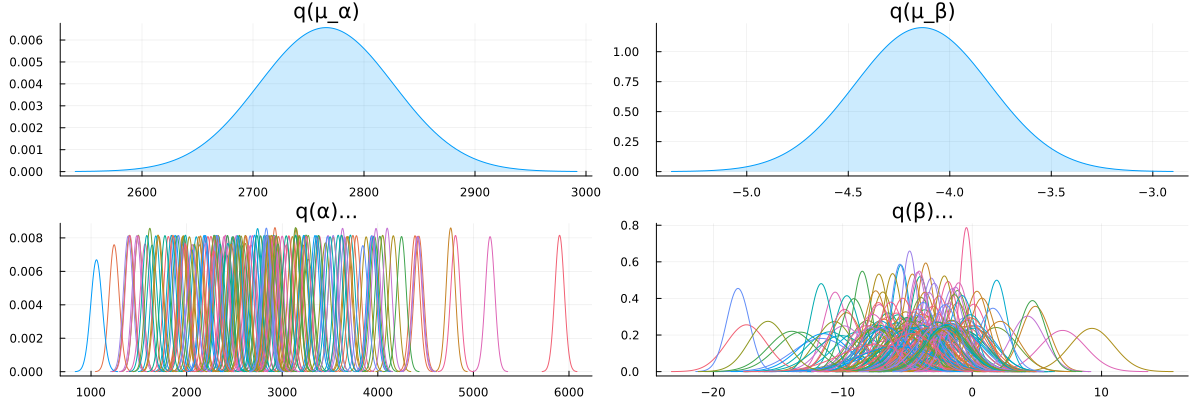

In [19]:
# Convert to `Normal` since it supports easy plotting with `StatsPlots`
let 
    local μ_α = Normal(mean_std(partially_pooled_inference_results.posteriors[:μ_α])...)
    local μ_β = Normal(mean_std(partially_pooled_inference_results.posteriors[:μ_β])...)
    local α = map(d -> Normal(mean_std(d)...), partially_pooled_inference_results.posteriors[:α])
    local β = map(d -> Normal(mean_std(d)...), partially_pooled_inference_results.posteriors[:β])
    
    local p1 = plot(μ_α, title = "q(μ_α)", fill = 0, fillalpha = 0.2, label = false)
    local p2 = plot(μ_β, title = "q(μ_β)", fill = 0, fillalpha = 0.2, label = false)
    
    local p3 = plot(title = "q(α)...", legend = false)
    local p4 = plot(title = "q(β)...", legend = false)
    
    foreach(d -> plot!(p3, d), α) # Add each individual `α` on plot `p3`
    foreach(d -> plot!(p4, d), β) # Add each individual `β` on plot `p4`
    
    plot(p1, p2, p3, p4, size = (1200, 400), layout = @layout([ a b; c d ]))
end

Looks like our model learned personalized alphas and betas for each patient!

# 4.2. Visualizing FVC decline curves for some patients

Now, let's visually inspect the FVC decline curves predicted by our model. We will complete the FVC table by predicting all the missing values. To do this, we need to create a table to accommodate the predictions.

In [20]:
function patientchart_bayesian(results, dataset, encoder, patient_id; kwargs...)
    info            = patientinfo(dataset, patient_id)
    patient_code_id = encoder[patient_id]

    patient_α = results.posteriors[:α][patient_code_id]
    patient_β = results.posteriors[:β][patient_code_id]
    
    predict_weeks = range(-12, 134)

    predicted = map(predict_weeks) do week
        pm = mean(patient_α) + mean(patient_β) * week
        pv = var(patient_α) + var(patient_β) * week ^ 2
        return pm, sqrt(pv)
    end
    
    p = patientchart(dataset, patient_id; kwargs...)
    
    return plot!(p, predict_weeks, getindex.(predicted, 1), ribbon = getindex.(predicted, 2), color = :orange)
end

patientchart_bayesian (generic function with 1 method)

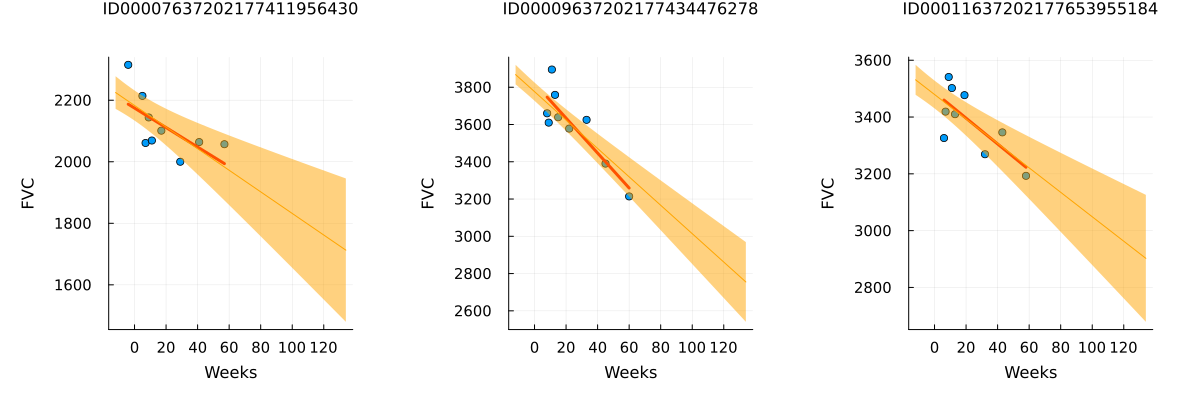

In [21]:
p1 = patientchart_bayesian(partially_pooled_inference_results, dataset, patient_code_encoder, "ID00007637202177411956430")
p2 = patientchart_bayesian(partially_pooled_inference_results, dataset, patient_code_encoder, "ID00009637202177434476278")
p3 = patientchart_bayesian(partially_pooled_inference_results, dataset, patient_code_encoder, "ID00011637202177653955184")

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1200, 400))

The results match our expectations perfectly! Let's highlight the observations:

- The model successfully learned Bayesian Linear Regressions! The orange line representing the learned predicted FVC mean closely aligns with the red line representing the deterministic linear regression. More importantly, the model effectively predicts uncertainty, demonstrated by the light orange region surrounding the mean FVC line.

- The model predicts higher uncertainty in cases where the data points are more dispersed, such as in the 1st and 3rd patients. In contrast, when data points are closely grouped together, as seen in the 2nd patient, the model predicts higher confidence, resulting in a narrower light orange region.

- Additionally, across all patients, we observe that the uncertainty increases as we look further into the future. The light orange region widens as the number of weeks increases, reflecting the growth of uncertainty over time.

# 4.3. Computing the modified Laplace Log Likelihood and RMSE

As mentioned earlier, the competition evaluated models using a modified version of the Laplace Log Likelihood, which takes into account both the accuracy and certainty of each prediction—a valuable feature in medical applications.

To compute the metric, we predicted both the FVC value and its associated confidence measure (standard deviation σ). The metric is given by the formula:

$$\begin{equation}
    \begin{aligned}
        \sigma_{\mathrm{clipped}} &= \max(\sigma, 70) \\
        \delta &= \min(\vert \mathrm{FVC}_{\mathrm{true}} - \mathrm{FVC}_{\mathrm{pred}}\vert, 1000) \\
        \mathrm{metric} &= -\frac{\sqrt{2}\delta}{\sigma_{\mathrm{clipped}}} - \mathrm{ln}(\sqrt{2}\sigma_{\mathrm{clipped}}) \\
    \end{aligned}
\end{equation}$$

To prevent large errors from disproportionately penalizing results, errors were thresholded at 1000 ml. Additionally, confidence values were clipped at 70 ml to account for the approximate measurement uncertainty in FVC. The final score was determined by averaging the metric across all (Patient, Week) pairs. It is worth noting that metric values will be negative, and a higher score indicates better model performance.

In [22]:
function FVC_predict(results)
    # TODO: Manually compute predictive distributions over the observations
    # Should be implemented as a feature of the toolbox
    return broadcast(results.posteriors[:FVC_est], Ref(results.posteriors[:σ])) do f, s
        return @call_rule NormalMeanPrecision(:out, Marginalisation) (m_μ = f, q_τ = s)
    end
end

FVC_predict (generic function with 1 method)

In [23]:
function compute_rmse(results, dataset)
    FVC_predicted = FVC_predict(results)
    return mean((dataset[!, "FVC"] .- mean.(FVC_predicted)) .^ 2) ^ (1/2)
end

function compute_laplace_log_likelihood(results, dataset)
    FVC_predicted = FVC_predict(results)
    sigma_c = std.(FVC_predicted)
    sigma_c[sigma_c .< 70] .= 70
    delta = abs.(mean.(FVC_predicted) .- dataset[!, "FVC"])
    delta[delta .> 1000] .= 1000
    return mean(-sqrt(2) .* delta ./ sigma_c .- log.(sqrt(2) .* sigma_c))
end

compute_laplace_log_likelihood (generic function with 1 method)

In [24]:
println("RMSE: $(compute_rmse(partially_pooled_inference_results, dataset))")
println("Laplace Log Likelihood: $(compute_laplace_log_likelihood(partially_pooled_inference_results, dataset))")

RMSE: 124.0313266260767


Laplace Log Likelihood: -6.15689374755478


What do these numbers signify? They indicate that adopting this approach would lead to outperforming the majority of public solutions in the competition. In several seconds of inference!

Interestingly, most public solutions rely on a standard deterministic Neural Network and attempt to model uncertainty through a quantile loss, adhering to a frequentist approach. The importance of uncertainty in single predictions is growing in the field of machine learning, becoming a crucial requirement. Especially when the consequences of an inaccurate prediction are significant, knowing the probability distribution of individual predictions becomes essential.

# 5. Add layer to model hierarchy: Smoking Status

We can enhance the model by incorporating the column "SmokingStatus" as a pooling level, where model parameters will be partially pooled within the groups "Never smoked," "Ex-smoker," and "Currently smokes." To achieve this, we need to:

Encode the "SmokingStatus" column.
Map the patient encoding to the corresponding "SmokingStatus" encodings.
Refine and retrain the model with the additional hierarchical structure.

In [25]:
combine(groupby(dataset, "SmokingStatus"), nrow)

3×2 DataFrame
 Row │ SmokingStatus     nrow  
     │ String31          Int64 
─────┼─────────────────────────
   1 │ Ex-smoker          1038
   2 │ Never smoked        429
   3 │ Currently smokes     82

In [26]:
smoking_id_mapping   = Dict(map(((code, smoking_status), ) -> smoking_status => code, enumerate(unique(dataset[!, "SmokingStatus"]))))
smoking_code_encoder = Dict(map(unique(values(patient_ids))) do patient_id
    smoking_status = first(unique(patientinfo(dataset, patient_id)[!, "SmokingStatus"]))
    return patient_code_encoder[patient_id] => smoking_id_mapping[smoking_status]
end)

smoking_status_patient_mapping = map(id -> smoking_code_encoder[id], 1:length(unique(patient_ids)));

In [27]:
@model function partially_pooled_with_smoking(patient_codes, smoking_status_patient_mapping, weeks)
    μ_α_global ~ Normal(mean = 0.0, var = 250000.0) # Prior for the mean of α (intercept)
    μ_β_global ~ Normal(mean = 0.0, var = 250000.0) # Prior for the mean of β (slope)
    σ_α_global ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0
    σ_β_global ~ Gamma(shape = 1.75, scale = 1.36)  # Corresponds to half-normal with scale 3.0

    n_codes = length(patient_codes) # Total number of data points
    n_smoking_statuses = length(unique(smoking_status_patient_mapping)) # Number of different smoking patterns
    n_patients = length(unique(patient_codes)) # Number of unique patients in the data

    μ_α_smoking_status = randomvar(n_smoking_statuses) # Individual intercepts for smoking pattern
    μ_β_smoking_status = randomvar(n_smoking_statuses) # Individual slopes for smoking pattern
    
    for i in 1:n_smoking_statuses
        μ_α_smoking_status[i] ~ Normal(mean = μ_α_global, precision = σ_α_global)
        μ_β_smoking_status[i] ~ Normal(mean = μ_β_global, precision = σ_β_global)
    end
    
    α = randomvar(n_patients) # Individual intercepts for each patient
    β = randomvar(n_patients) # Individual slopes for each patient

    for i in 1:n_patients
        α[i] ~ Normal(mean = μ_α_smoking_status[smoking_status_patient_mapping[i]], precision = σ_α_global)
        β[i] ~ Normal(mean = μ_β_smoking_status[smoking_status_patient_mapping[i]], precision = σ_β_global)
    end

    σ ~ Gamma(shape = 1.75, scale = 45.54) # Corresponds to half-normal with scale 100.0

    FVC_est = randomvar(n_codes)
    data = datavar(Int, n_codes)

    for i in 1:n_codes
        FVC_est[i] ~ α[patient_codes[i]] + β[patient_codes[i]] * weeks[i] # FVC estimation using patient-specific α and β
        data[i] ~ Normal(mean = FVC_est[i], precision = σ)              # Likelihood of the observed FVC data
    end
    
end

@constraints function partially_pooled_with_smooking_constraints()
    q(μ_α_global, σ_α_global, μ_β_global, σ_β_global) = q(μ_α_global)q(σ_α_global)q(μ_β_global)q(σ_β_global)
    q(μ_α_smoking_status, μ_β_smoking_status, σ_α_global, σ_β_global) = q(μ_α_smoking_status)q(μ_β_smoking_status)q(σ_α_global)q(σ_β_global)
    q(μ_α_global, σ_α_global, μ_β_global, σ_β_global, σ) = q(μ_α_global)q(σ_α_global)q(μ_β_global)q(σ_β_global)q(σ)
    q(μ_α_global, σ_α_global, α) = q(μ_α_global, α)q(σ_α_global)
    q(μ_β_global, σ_β_global, β) = q(μ_β_global, β)q(σ_β_global)
    q(FVC_est, σ) = q(FVC_est)q(σ) 
end

partially_pooled_with_smooking_constraints (generic function with 1 method)

In [28]:
function partially_pooled_with_smoking(dataset, smoking_status_patient_mapping)
    patient_codes = values(dataset[!, "PatientCode"])
    weeks = values(dataset[!, "Weeks"])
    FVC_obs = values(dataset[!, "FVC"]);
    
    return inference(
        model = partially_pooled_with_smoking(patient_codes, smoking_status_patient_mapping, weeks),
        data = (data = FVC_obs, ),
        options = (limit_stack_depth = 500, ),
        constraints = partially_pooled_with_smooking_constraints(),
        initmessages = (
            α = vague(NormalMeanVariance),
            β = vague(NormalMeanVariance),
        ),
        initmarginals = (
            σ = Gamma(1.75, 45.54),
            σ_α_global = Gamma(1.75, 45.54),
            σ_β_global = Gamma(1.75, 1.36),
        ),
        returnvars = KeepLast(),
        iterations = 100,
    )
end

partially_pooled_with_smoking (generic function with 2 methods)

In [29]:
partially_pooled_with_smoking_inference_results = partially_pooled_with_smoking(dataset, smoking_status_patient_mapping);

In [30]:
@benchmark partially_pooled_with_smoking($dataset, $smoking_status_patient_mapping)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.948 s …   3.085 s  ┊ GC (min … max):  9.56% … 11.51%
 Time  (median):     3.017 s              ┊ GC (median):    10.56%
 Time  (mean ± σ):   3.017 s ± 96.760 ms  ┊ GC (mean ± σ):  10.56% ±  1.38%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.95 s         Histogram: frequency by time        3.08 s <

 Memory estimate: 592.78 MiB, allocs estimate: 15214705.

# 5.1. Inspect the learned parameters


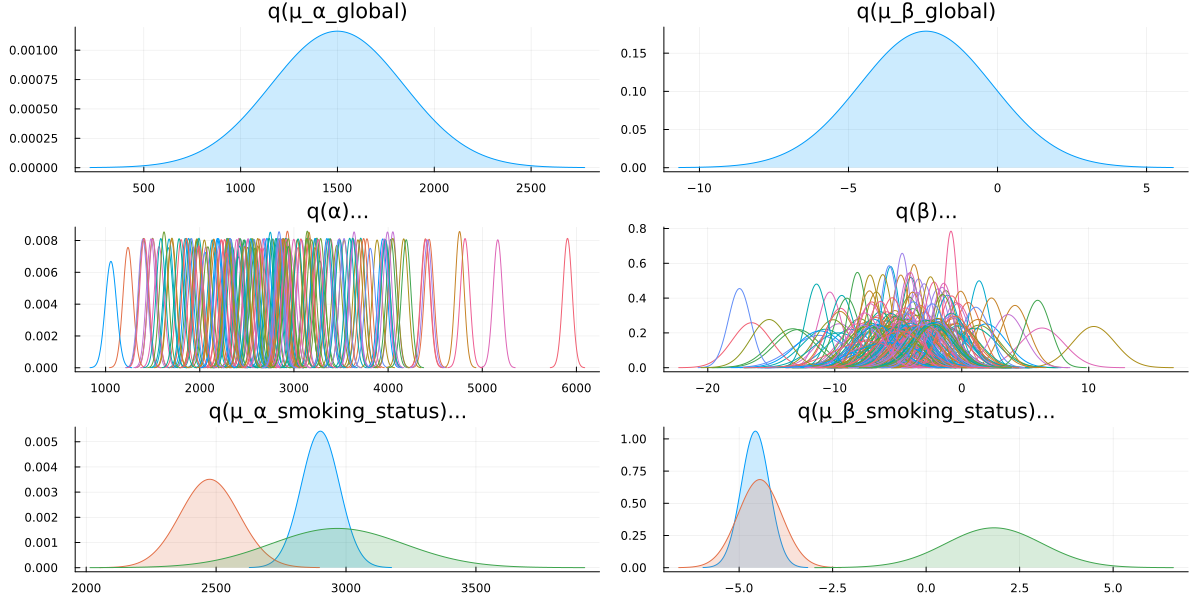

In [31]:
# Convert to `Normal` since it supports easy plotting with `StatsPlots`
let 
    local μ_α = Normal(mean_std(partially_pooled_with_smoking_inference_results.posteriors[:μ_α_global])...)
    local μ_β = Normal(mean_std(partially_pooled_with_smoking_inference_results.posteriors[:μ_β_global])...)
    local αsmoking = map(d -> Normal(mean_std(d)...), partially_pooled_with_smoking_inference_results.posteriors[:μ_α_smoking_status])
    local βsmoking = map(d -> Normal(mean_std(d)...), partially_pooled_with_smoking_inference_results.posteriors[:μ_β_smoking_status])
    local α = map(d -> Normal(mean_std(d)...), partially_pooled_with_smoking_inference_results.posteriors[:α])
    local β = map(d -> Normal(mean_std(d)...), partially_pooled_with_smoking_inference_results.posteriors[:β])
    
    local p1 = plot(μ_α, title = "q(μ_α_global)", fill = 0, fillalpha = 0.2, label = false)
    local p2 = plot(μ_β, title = "q(μ_β_global)", fill = 0, fillalpha = 0.2, label = false)
    
    local p3 = plot(title = "q(α)...", legend = false)
    local p4 = plot(title = "q(β)...", legend = false)
    
    foreach(d -> plot!(p3, d), α) # Add each individual `α` on plot `p3`
    foreach(d -> plot!(p4, d), β) # Add each individual `β` on plot `p4`
    
    local p5 = plot(title = "q(μ_α_smoking_status)...", legend = false)
    local p6 = plot(title = "q(μ_β_smoking_status)...", legend = false)
    
    foreach(d -> plot!(p5, d, fill = 0, fillalpha = 0.2), αsmoking) 
    foreach(d -> plot!(p6, d, fill = 0, fillalpha = 0.2), βsmoking)
    
    plot(p1, p2, p3, p4, p5, p6, size = (1200, 600), layout = @layout([ a b; c d; e f ]))
end

## Interpret smoking status model parameters

The model parameters for each smoking status reveal intriguing findings, particularly concerning the trend, μ_β_smoking_status. In the summary below, it is evident that the trend for current smokers has a positive mean, while the trend for ex-smokers and those who have never smoked is negative.

In [32]:
smoking_id_mapping

Dict{String31, Int64} with 3 entries:
  "Currently smokes" => 3
  "Ex-smoker"        => 1
  "Never smoked"     => 2

In [33]:
posteriors_μ_β_smoking_status = partially_pooled_with_smoking_inference_results.posteriors[:μ_β_smoking_status]

println("Trend for")
foreach(pairs(smoking_id_mapping)) do (key, id)
    println("  $key: $(mean(posteriors_μ_β_smoking_status[id]))")
end

Trend for
  Currently smokes: 1.815745767102511
  Ex-smoker: -4.565164617653452
  Never smoked: -4.446729680169412


Let's look at these curves for individual patients to help interpret these model results.

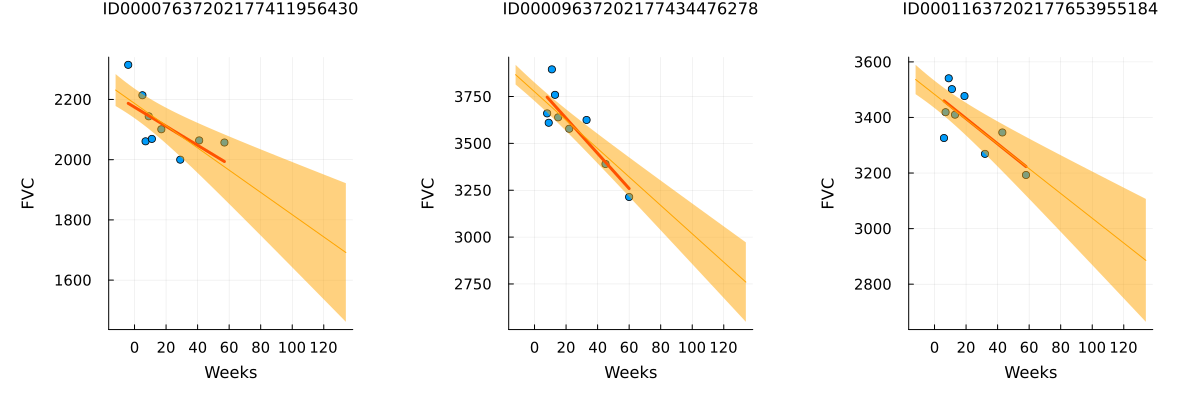

In [34]:
# Never smoked
p1 = patientchart_bayesian(partially_pooled_with_smoking_inference_results, dataset, patient_code_encoder, "ID00007637202177411956430") 
# Ex-smoker
p2 = patientchart_bayesian(partially_pooled_with_smoking_inference_results, dataset, patient_code_encoder, "ID00009637202177434476278") 
# Currently smokes
p3 = patientchart_bayesian(partially_pooled_with_smoking_inference_results, dataset, patient_code_encoder, "ID00011637202177653955184") 

plot(p1, p2, p3, layout = @layout([ a b c ]), size = (1200, 400))

# Review patients that currently smoke

When plotting each patient with the smoking status "Currently smokes," we observe different trends. Some patients show a clear positive trend, while others do not exhibit a clear trend or even have a negative trend. Compared to the unpooled trend lines, the trend lines with partial pooling are less prone to overfitting and display greater uncertainty in both slope and intercept.

Depending on the purpose of the model, we can proceed in different ways:

- If our goal is to gain insights into how different attributes relate to a patient's FVC over time, we can stop here and understand that current smokers might experience an increase in FVC over time when monitored for Pulmonary Fibrosis. We may then formulate hypotheses to explore the reasons behind this observation and design new experiments for further testing.

- However, if our aim is to develop a model for generating predictions to treat patients, it becomes crucial to ensure that the model does not overfit and can be trusted with new patients. To achieve this, we could adjust model parameters to shrink the "Currently smokes" group's parameters closer to the global parameters, or even consider merging the group with "Ex-smokers." Additionally, collecting more data for current smokers could help in ensuring the model's robustness and preventing overfitting.

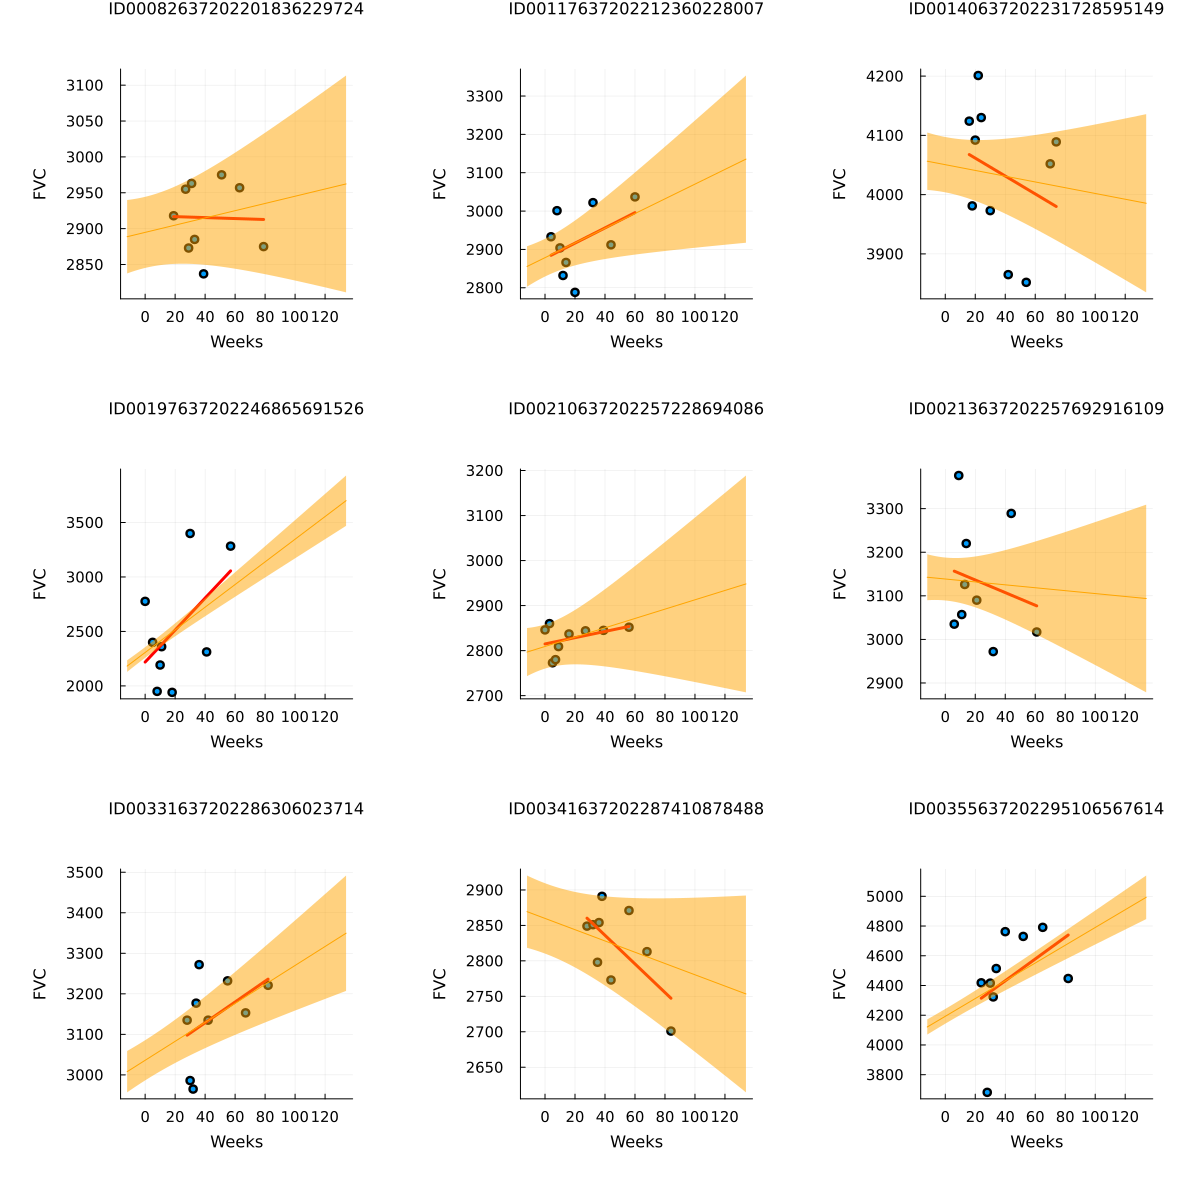

In [35]:
let 
    local plots = []

    for (i, patient) in enumerate(unique(filter(:SmokingStatus => ==("Currently smokes"), dataset)[!, "Patient"]))
        push!(plots, patientchart_bayesian(partially_pooled_with_smoking_inference_results, dataset, patient_code_encoder, patient))
    end

    plot(plots..., size = (1200, 1200))
end

# 5.3 Modified Laplace Log Likelihood and RMSE for model with Smoking Status Level

We calculate the metrics for the updated model and compare to the original model.

In [36]:
println("RMSE: $(compute_rmse(partially_pooled_with_smoking_inference_results, dataset))")
println("Laplace Log Likelihood: $(compute_laplace_log_likelihood(partially_pooled_with_smoking_inference_results, dataset))")

RMSE: 124.7845980866074
Laplace Log Likelihood: -6.165346437287479


Both the Laplace Log Likelihood and RMSE indicate slightly worse performance for the smoking status model. Adding this hierarchy level as it is did not improve the model's performance significantly. However, we did discover some interesting results from the smoking status level that might warrant further investigation. Additionally, we could attempt to enhance model performance by adjusting priors or exploring different hierarchy levels, such as gender.

# References
[1] Ghahramani, Z. Probabilistic machine learning and artificial intelligence. Nature 521, 452–459 (2015). https://doi.org/10.1038/nature14541

[2] Rainforth, Thomas William Gamlen. Automating Inference, Learning, and Design Using Probabilistic Programming. University of Oxford, 2017.